In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlx.core as mx
import mlx.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score
from utils import *
import os
from pathlib import Path


In [3]:
df = pd.read_csv("results.csv")

In [9]:
df[df["Dataset"]=="socialiqa"].head(20)

,Unnamed: 0,Empresa,Dataset,Modelo,Base/Fine-tuning,Capas LoRa,Tamaño batch,Learning rate,Iters,Adapter,Accuracy,Proportion Targets in Softmax,Accuracy restringido,Entropía cruzada,Entropía cruzada normalizada
0,0,mistralai,socialiqa,Mistral-7B-v0.1,Base,NaN,NaN,NaN,5000,NaN,0.423746,0.401310,0.574719,10.373392,0.999991
2,2,microsoft,socialiqa,phi-1.5,Fine-tuning,16.0,4.0,0.00001,5000,Best,0.590583,0.990771,0.590583,10.843143,0.999968
3,3,microsoft,socialiqa,phi-1.5,Fine-tuning,8.0,4.0,0.00001,5000,Best,0.590583,0.990771,0.590583,10.843143,0.999968
4,4,microsoft,socialiqa,phi-1.5,Fine-tuning,24.0,4.0,0.00001,5000,Best,0.590583,0.990771,0.590583,10.843143,0.999968
5,5,microsoft,socialiqa,phi-1.5,Base,NaN,NaN,NaN,5000,NaN,0.590583,0.990771,0.590583,10.843143,0.999968


## Curvas de pérdida

In [ ]:
directories = ["../output/microsoft/phi-1.5/socialiqa_avance/8/4",
               "../output/microsoft/phi-1.5/socialiqa_avance/8/8",
                "../output/microsoft/phi-1.5/socialiqa_avance/8/16",
                "../output/microsoft/phi-1.5/socialiqa_jsonl",
                "../output/mistralai/Mistral-7B-v0.1/socialiqa_jsonl"]

In [ ]:
for a_set in ["Train", "Val"]:
    df_train_loss = pd.read_csv(directories[0] + "/Train_loss.csv")
    # Check if 'Unnamed: 0' is one of the columns and drop it if present
    if 'Unnamed: 0' in df_train_loss.columns:
        df_train_loss.drop('Unnamed: 0', axis=1, inplace=True)
    df_train_loss

In [ ]:
import pandas as pd

# Create a dictionary to hold the dataframes
dataframes = {}

for a_set in ["Train", "Val"]:
    # Construct the filename based on the current set
    filename = f"{directories[0]}/{a_set}_loss.csv"
    
    # Read the CSV file
    df = pd.read_csv(filename)
    
    # Check if 'Unnamed: 0' is one of the columns and drop it if present
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # Store the dataframe in the dictionary with a key
    dataframes[f'{a_set}_loss'] = df

# Now you can access each dataframe using its key in the dictionary
# print(dataframes['Train_loss'])
# print(dataframes['Val_loss'])


## Curvas de pérdida

### 1. Funciones para manejar la carga y procesamiento de datos

In [ ]:
import pandas as pd
import os
import glob
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

def load_and_process_csv(filepath, set_name):
    """Carga y procesa un archivo CSV, eliminando columnas innecesarias."""
    df = pd.read_csv(filepath)
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace=True)
    df['Type'] = set_name
    return df

def load_yaml_configuration(filepath):
    """Carga la configuración de un archivo YAML."""
    with open(filepath, 'r') as file:
        params = yaml.safe_load(file)
    params['model'] = params['model'].replace("/", "-")
    return params

def find_yaml_file(directory):
    """Encuentra y valida un archivo YAML en el directorio especificado."""
    yaml_files = glob.glob(os.path.join(directory, '*.yaml'))
    if not yaml_files:
        raise FileNotFoundError("No se encontró ningún archivo YAML en el directorio.")
    if len(yaml_files) > 1:
        raise RuntimeError("Se encontraron múltiples archivos YAML en el directorio. Asegúrate de tener solo uno.")
    return yaml_files[0]


### 2. Función para combinar y filtrar DataFrames


In [ ]:
def combine_and_filter_dataframes(train_df, val_df):
    """Combina y filtra DataFrames de entrenamiento y validación."""
    val_df.rename(columns={'Val': 'Loss'}, inplace=True)
    combined_df = pd.concat([train_df, val_df])
    filtered_df = combined_df[combined_df['Loss'] <= 1]
    return filtered_df


### 3. Función para graficar los resultados


In [ ]:
def plot_data(data, title, save_path):
    """Grafica y guarda los datos de pérdida de entrenamiento y validación."""
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x='Iteration', y='Loss', hue='Type', style='Type', markers=True, dashes=False)
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend(title='Dataset')
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

### 4. Función principal que usa las funciones definidas


In [ ]:
root_directory = '../output/'
ignore_folders = ['adapters', 'adapters_best_val', 'tokenizer', 'resultados con adapters',"socialiqa_debug"]

leaf_dirs = list_leaf_directories(root_directory, ignore_folders)
leaf_dirs

for dir in leaf_dirs:
    #print("Procesando directorio:", dir)
    info_experimento = parse_path(dir)
    info_experimento.keys()
    if info_experimento["Base/Fine-tuning"]=="Fine-tuning":
        

In [ ]:
info_experimento.keys()

dict_keys(['Empresa', 'Modelo', 'Dataset', 'Capas LoRa', 'Tamaño batch', 'Learning rate', 'Base/Fine-tuning', 'Adapter'])

In [ ]:
def main():

    directories = list_leaf_directories
        
    dataframes = {}
    
    for directory in directories:
        for a_set in ["Train", "Val"]:
            file_path = os.path.join(directory, f"{a_set}_loss.csv")
            dataframes[f'{a_set}_loss'] = load_and_process_csv(file_path, a_set)

        yaml_file_path = find_yaml_file(directory)
        params = load_yaml_configuration(yaml_file_path)
        model_name = params['model']
        lora_layers = params['lora-layers']
        batch_size = params['batch-size']
        
        if lora_layers and batch_size:
            title = f'{model_name} con {lora_layers} LoRA Layers - Training vs. Validation Loss Over Iterations (Loss ≤ 1)'
        else:
            title = f'{model_name} base - Training vs. Validation Loss Over Iterations (Loss ≤ 1)'
        
        save_path = os.path.join(directory, f"{model_name}_with_{lora_layers}_LoRA_Layers_Training_vs_Validation_Loss.png")

        filtered_data = combine_and_filter_dataframes(dataframes['Train_loss'], dataframes['Val_loss'])
        plot_data(filtered_data, title, save_path)


Processing directory: ../output/microsoft/phi-1.5/socialiqa_avance/8/4
Loaded and processed ../output/microsoft/phi-1.5/socialiqa_avance/8/4/Train_loss.csv
Loaded and processed ../output/microsoft/phi-1.5/socialiqa_avance/8/4/Val_loss.csv
Plotting data for ../output/microsoft/phi-1.5/socialiqa_avance/8/4


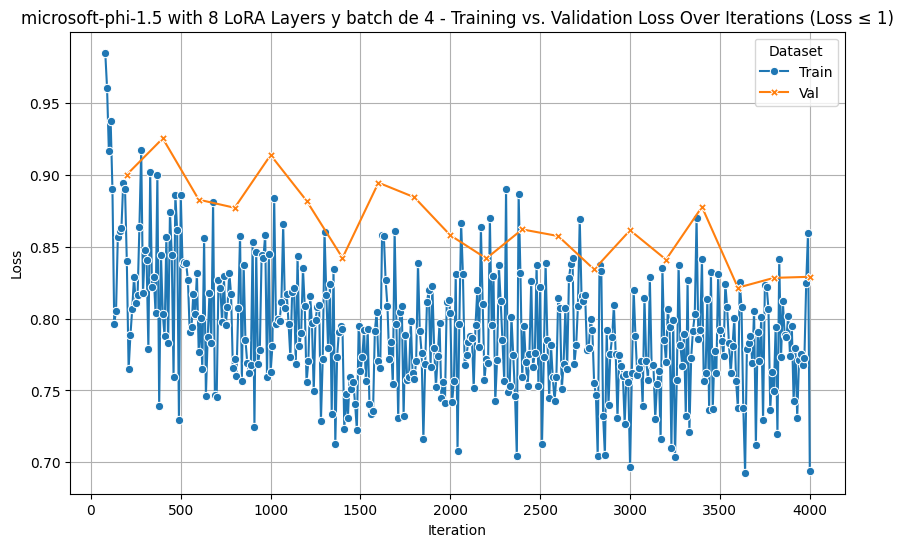

Processing directory: ../output/microsoft/phi-1.5/socialiqa_avance/8/8
Loaded and processed ../output/microsoft/phi-1.5/socialiqa_avance/8/8/Train_loss.csv
Loaded and processed ../output/microsoft/phi-1.5/socialiqa_avance/8/8/Val_loss.csv
Plotting data for ../output/microsoft/phi-1.5/socialiqa_avance/8/8


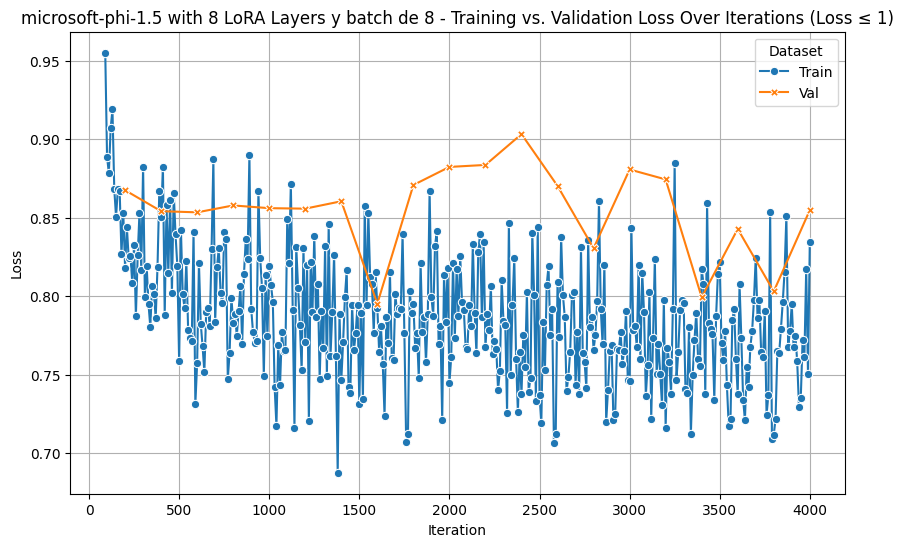

Processing directory: ../output/microsoft/phi-1.5/socialiqa_avance/8/16
Loaded and processed ../output/microsoft/phi-1.5/socialiqa_avance/8/16/Train_loss.csv
Loaded and processed ../output/microsoft/phi-1.5/socialiqa_avance/8/16/Val_loss.csv
Plotting data for ../output/microsoft/phi-1.5/socialiqa_avance/8/16


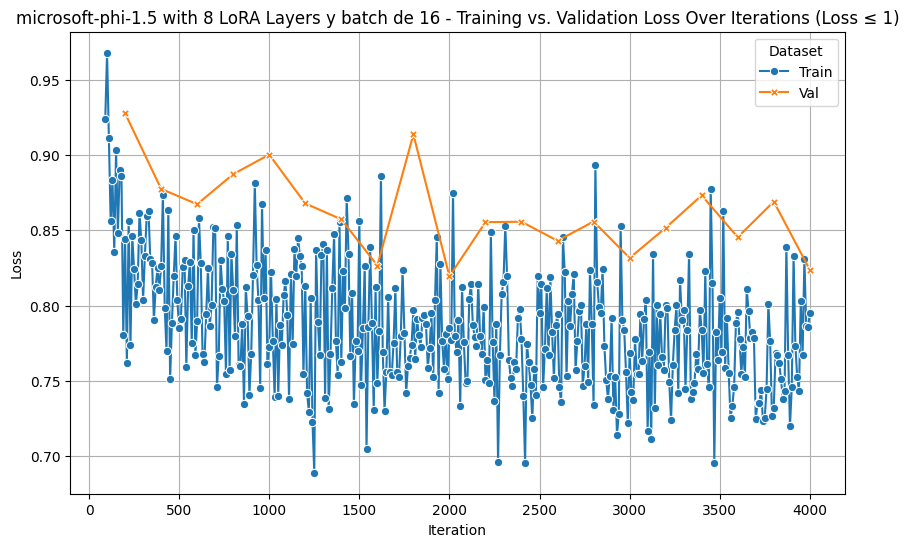

In [ ]:
import os

def main():
    directories = [
        "../output/microsoft/phi-1.5/socialiqa_avance/8/4",
        "../output/microsoft/phi-1.5/socialiqa_avance/8/8",
        "../output/microsoft/phi-1.5/socialiqa_avance/8/16",
    ]
    
    dataframes = {}
    
    for directory in directories:
        print(f"Processing directory: {directory}")
        for a_set in ["Train", "Val"]:
            file_path = os.path.join(directory, f"{a_set}_loss.csv")
            if not os.path.exists(file_path):
                print(f"Warning: File {file_path} does not exist. Skipping.")
                continue
            dataframes[f'{a_set}_loss'] = load_and_process_csv(file_path, a_set)
            print(f"Loaded and processed {file_path}")

        try:
            yaml_file_path = find_yaml_file(directory)
            params = load_yaml_configuration(yaml_file_path)
        except Exception as e:
            print(f"Error loading YAML configuration: {e}")
            continue
        
        model_name = params.get('model', 'Unknown Model')
        lora_layers = params.get('lora-layers', 'No LoRA Layers')
        batch_size = params.get('batch-size', 'No Batch Size')

        title = f'{model_name} with {lora_layers} LoRA Layers y batch de {batch_size} - Training vs. Validation Loss Over Iterations (Loss ≤ 1)'
        
        save_path = os.path.join(os.getcwd(), f"{title}.png")
        if 'Train_loss' in dataframes and 'Val_loss' in dataframes:
            filtered_data = combine_and_filter_dataframes(dataframes['Train_loss'], dataframes['Val_loss'])
            print(f"Plotting data for {directory}")
            plot_data(filtered_data, title, save_path)
        else:
            print(f"DataFrames for training or validation are missing in {directory}")

        # Reset dataframes dictionary for the next directory
        dataframes = {}

if __name__ == "__main__":
    main()


In [ ]:
for dir in leaf_dirs:
    try:
        print("Procesando directorio:", dir)
        info_experimento = parse_path(dir)

        # Intenta cargar los logits; si el archivo no existe, captura la excepción y continúa
        try:
            logits = np.load(dir + "/test_all_logits.npy")
        except FileNotFoundError:
            print(f"No se pudo encontrar 'test_all_logits.npy' en {dir}, saltando este directorio.")
            continue  # Salta al próximo directorio en el bucle

        # Proceso similar para 'targets'
        try:
            targets = np.load(dir + "/test_all_targets.npy")
        except FileNotFoundError:
            print(f"No se pudo encontrar 'test_all_targets.npy' en {dir}, saltando este directorio.")
            continue

        # Si ambos archivos existen, procede con el procesamiento
        np.bincount(targets, minlength=3)
        values, counts = np.unique(targets, return_counts=True)
        counts / sum(counts)

        predictions = np.argmax(logits, axis=1)
        accuracy = accuracy_score(targets, predictions)

        logits_sf = mx.softmax(mx.array(logits), axis=1)
        indices = np.unique(targets)
        selected_logits = np.take(logits_sf, indices, axis=1)
        priors_to_targets = np.sum(selected_logits, axis=1).mean()

        relevant_logits = logits[:, indices]
        predictions = np.argmax(relevant_logits, axis=1)

        index_to_position = {index: pos for pos, index in enumerate(indices)}
        mapped_targets = np.array([index_to_position[target] for target in targets if target in index_to_position])
        accuracy_restricted = accuracy_score(mapped_targets, predictions)

        cross_entropy = nn.losses.cross_entropy(mx.array(logits), mx.array(targets), reduction="mean").item()
        priors = np.bincount(targets, minlength=logits.shape[1]) / targets.shape[0]
        priors = np.repeat(priors.reshape(1, -1), len(targets), axis=0)
        cross_entropy_priors = nn.losses.cross_entropy(mx.array(np.log(priors)), mx.array(targets), reduction="mean").item()

        # Preparar un DataFrame temporal con los resultados para este directorio
        temp_df = pd.DataFrame({
            "Empresa": info_experimento["Empresa"],
            "Modelo": info_experimento["Modelo"],
            "Capas LoRa": info_experimento["Capas LoRa"],
            "Tamaño batch": info_experimento["Tamaño batch"],
            "Learning rate": info_experimento["Learning rate"],
            "Adapter": "Last",
            "Accuracy": [accuracy],
            "Proportion Targets in Softmax": [priors_to_targets],
            "Accuracy restringido": [accuracy_restricted],
            "Entropía cruzada": [cross_entropy],
            "Entropía cruzada normalizada": [cross_entropy / cross_entropy_priors],
        })

        # Concatenar el DataFrame temporal al principal
        results_df = pd.concat([results_df, temp_df], ignore_index=True)

    except Exception as e:
        print(f"Ocurrió un error inesperado procesando el directorio {dir}: {str(e)}")


In [ ]:
for dir in leaf_dirs:
    try:
        print("Procesando directorio:", dir)
        info_experimento = parse_path(dir)

        # Intenta cargar los logits; si el archivo no existe, captura la excepción y continúa
        try:
            logits = np.load(dir + "/test_all_logits.npy")
        except FileNotFoundError:
            print(f"No se pudo encontrar 'test_all_logits.npy' en {dir}, saltando este directorio.")
            continue  # Salta al próximo directorio en el bucle

        # Proceso similar para 'targets'
        try:
            targets = np.load(dir + "/test_all_targets.npy")
        except FileNotFoundError:
            print(f"No se pudo encontrar 'test_all_targets.npy' en {dir}, saltando este directorio.")
            continue

        # Si ambos archivos existen, procede con el procesamiento
        np.bincount(targets, minlength=3)
        values, counts = np.unique(targets, return_counts=True)
        counts / sum(counts)

        predictions = np.argmax(logits, axis=1)
        accuracy = accuracy_score(targets, predictions)

        logits_sf = mx.softmax(mx.array(logits), axis=1)
        indices = np.unique(targets)
        selected_logits = np.take(logits_sf, indices, axis=1)
        priors_to_targets = np.sum(selected_logits, axis=1).mean()

        relevant_logits = logits[:, indices]
        predictions = np.argmax(relevant_logits, axis=1)

        index_to_position = {index: pos for pos, index in enumerate(indices)}
        mapped_targets = np.array([index_to_position[target] for target in targets if target in index_to_position])
        accuracy_restricted = accuracy_score(mapped_targets, predictions)

        cross_entropy = nn.losses.cross_entropy(mx.array(logits), mx.array(targets), reduction="mean").item()
        priors = np.bincount(targets, minlength=logits.shape[1]) / targets.shape[0]
        priors = np.repeat(priors.reshape(1, -1), len(targets), axis=0)
        cross_entropy_priors = nn.losses.cross_entropy(mx.array(np.log(priors)), mx.array(targets), reduction="mean").item()

        # Preparar un DataFrame temporal con los resultados para este directorio
        temp_df = pd.DataFrame({
            "Empresa": info_experimento["Empresa"],
            "Modelo": info_experimento["Modelo"],
            "Capas LoRa": info_experimento["Capas LoRa"],
            "Tamaño batch": info_experimento["Tamaño batch"],
            "Learning rate": info_experimento["Learning rate"],
            "Adapter": "Last",
            "Accuracy": [accuracy],
            "Proportion Targets in Softmax": [priors_to_targets],
            "Accuracy restringido": [accuracy_restricted],
            "Entropía cruzada": [cross_entropy],
            "Entropía cruzada normalizada": [cross_entropy / cross_entropy_priors],
        })

        # Concatenar el DataFrame temporal al principal
        results_df = pd.concat([results_df, temp_df], ignore_index=True)

    except Exception as e:
        print(f"Ocurrió un error inesperado procesando el directorio {dir}: {str(e)}")
